# Bayesian Optimization

This tutorial provides a step-by-step guide to implementing Bayesian optimization from scratch. The Overall story is that we want to find the global minimum/maximum of an unknown function. The procedure consists of first fitting a Gaussian process to the existing samples from the objective function and through that fitted model, finding the most suitable next point to be sampled.

## Source
- #### [Github Repo](https://github.com/advafaeian/BayesianOptimization)

## introduction
This tutorial assumes that you are already familiar with the following concepts:
* [Bayesian Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)
* [Gaussian Processe](https://distill.pub/2019/visual-exploration-gaussian-processes/)

Basically, a Gaussian process is a multivariate normal variable with infinite dimensions. So if you have for example 2 samples from the objective function: $[x_1, y_1], [x_2, y_2]$, you will fit a bivariate normal variable to these existing data with $y_1, y_2$ as the observations of this bivariate normal variable.

We begin with importing a few libraries:

In [1]:
#basic imports
import numpy as np
import matplotlib.pyplot as plt


## Objective Function

Here we are going to find the maximum of the function of $y = sin(\pi x)$. But the caveat is we (actually, the machine) do not have the function :) <br>
We only can sample individual points from the function but with noise. That means we only can sample from $sin(\pi x) + noise$. <br>
Below you can see the code for the objective function. Also, we showed the plot of the function and 100 noisy observations from that function.    

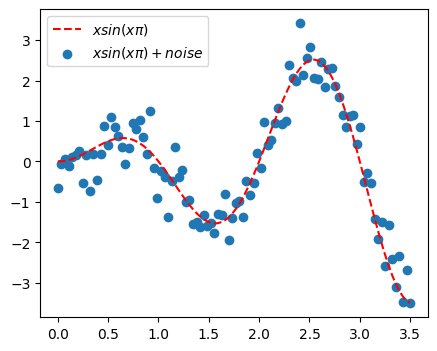

In [2]:
noise = .4
bounds=[0, 3.5] # The interval in which the maximum of the objective function should be found.

def objective_function(x, noise=noise):
    """Returns noisy observations from the objective function
    Args:
        x (float): The x for which y will be returned
        noise (float): The noise used as variance for normal random generation

    Returns:
        y (float): Output of the fucntion for the specific x
    """
    noise = np.random.normal(0, noise)
    y = x * np.sin(x * np.pi) + noise
    return y

plt.figure(figsize=(5, 4))
X = np.linspace(*bounds, 100)
means = [objective_function(x, 0) for x in X]
Y = [objective_function(x) for x in X]
plt.plot(X, means, "r--", label='$xsin(x\pi)$')
plt.scatter(X,Y, label="$xsin(x\pi) + noise$")
plt.legend(loc='best')
plt.show()

## Radial basis function kernel

For a multivariate normal variable with $n$ variables, we need $n$ means and a covariance matrix with $n \times n$ elements. The kernel function gives us the covariance matrix. The radial basis function is a kernel, among many, with the following formula: 
$$K(x, x') = exp(-\frac{{\left\| x - x' \right\|}^2}{2\sigma^2})$$
The plot shows the kernel outputs for various $x1$ and $x2$. Notice the closer $x1$ and $x2$, the higher the kernel output, which means the higher the covariance between $x1$ and $x2$.

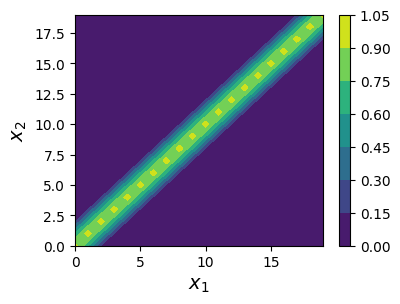

In [3]:
def rbf_kernel(x1, x2, sigma=1):
    """Radial basis function kernel
    Args:
        x1, x2 (float): Two points for which kernel output should be calculated
        sigma (float): Sigma free parameter

    Returns:
        rbf (float): Output of radial basis function kernel
    """
    xx, yy = np.meshgrid(x2, x1)
    rbf =  np.exp(-(xx - yy)**2/(2 * sigma**2))
    return rbf


xs = np.arange(20).reshape(-1,1)   
kernel = rbf_kernel(xs,xs)

plt.figure(figsize=(4, 3))
plt.contourf(kernel, cmap="viridis")
plt.colorbar() 
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.show()

## Fitting a Gaussian Process to the Data

This function fits a Gaussian process to the data and returns the parameters for that data, including means and a covariance matrix. <\br>
The fitting procedure involves finding estimates for the new data conditioned on previous data realization. 
Here comes the "Bayesian" part: the estimates for the new data are calculated provided the estimates for the previous data. Thus, the function receives the old x and y, `prev_x, prev_y`, in addition to the new data, `X`.

Thus, you have two multivariate normal variables, one for the previous data, and one for the new data 
The conditional means and covariance matrix for the new data are as follows:
$$\mu_{new|old} = \mu_{new} + \Sigma_{new.old} (\Sigma_{old.old} + \sigma I)^{-1}(x_{old} - \mu_{old})$$
$$ \Sigma_{new|old} = \Sigma_{new.new} - \Sigma_{old.new} (\Sigma_{old.old} + \sigma I)^{-1} \Sigma_{old.new} $$

Note that for simplicity, here we consider marginal means, $ {\mu_{new}}, {\mu_{old}} $, to be vectors of zeros. $I$ is the identity matrix, a matrix with 1s in the diagonals.

These two formulas are driven in Bishop's Pattern Recognition and Machine Learning book, section 2.3.1.

In [4]:

def fitted_gaus(X, prev_x, prev_y, noise):
    """Fitting gaussian processes on new Xs
    Args:
        X (float): New Xs to which the model should be fitted, shape: (n,)
        prev_x (float): Previous Xs to which the model has been already fitted, shape:(m,)
        prev_y (float): Noisy observation for prev_x, shape: (m,) 
        noise (float): The noise contributing to the objective funcntion output

    Returns:
        mean_a (float): Means for the new Xs from the fitted gaussian processes, shape: (n,)
        cov_a (float): Covariance matrix the new Xs from the fitted gaussian processes, shape: (n,n)
    """
    sigma_bb = rbf_kernel(prev_x, prev_x) + noise**2 * np.eye(prev_x.shape[0])
    sigma_aa= rbf_kernel(X, X) 
    sigma_ba = rbf_kernel(prev_x, X)
    sigma_ab = rbf_kernel(X, prev_x)

    sigma_bb_inv = np.linalg.inv(sigma_bb)

    mean_a = sigma_ab @ sigma_bb_inv @ prev_y
    cov_a = sigma_aa - (sigma_ab @ sigma_bb_inv @ sigma_ba)

    return mean_a, cov_a


In [5]:
def show_plot(X, Y, noise, title="", obj=True, gaus=True,legend=True):
    """Showing the plot for specific Xs and Ys
    Args:
        X (float): Xs for the plot, shape: (n,)
        Y (float): Ys for the plot, shape: (n,)
        noise (float): The noise contributing to the objective funcntion output
        title (string): The title which should be shown on the plot
        obj (bool): Whether the objective function should be plotted
        gaus (bool): Wheter the Gaussian process should be plotted
        legend (bool):  Whether to show the figure legend, default is set to True

    Returns:
        None
    """
    xs = np.linspace(*bounds, 100)
    ys =[objective_function(x, 0) for x in xs]
    means, cov_mat = fitted_gaus(xs, X, Y, noise)
    sds = np.sqrt(np.diag(cov_mat))
    if obj:
        plt.plot(xs, ys, 'r--', label="$xsin(x\pi)$")
    if gaus:    
        plt.scatter(X, Y, c="b", label="$(X, Y)$")
        plt.plot(xs, means, "y-", label="$\mu_{a|b}$")
        plt.fill_between(xs, means-2*sds, means+2*sds, color ='green', alpha=0.15, label="$\pm2\sigma_{a|b}$")
    if legend:
        plt.legend(loc="best")
    plt.ylim([-5,5])
    plt.title(title)
   
   
 

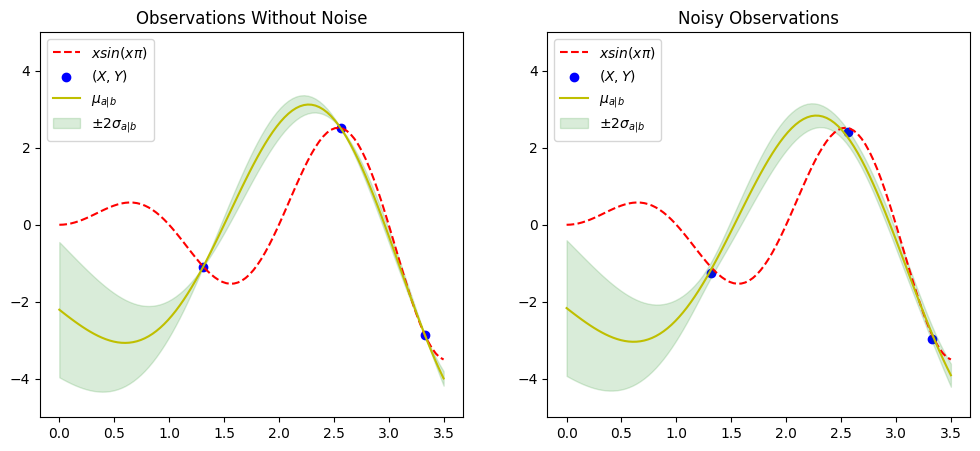

In [6]:
np.random.seed(42)
X = np.random.uniform(*bounds, 3)

plt.figure(figsize=(12, 5))

plt.subplot(121)
noise = 0
Y = [objective_function(x, noise) for x in X]
show_plot(X, Y, noise, title="Observations Without Noise")

plt.subplot(122)
noise = .1
Y = [objective_function(x, noise) for x in X]
show_plot(X, Y, noise, title="Noisy Observations")

plt.show()


## Expected Improvement
This is called the "acquisition function". There are multiple functions used in Bayesian optimization but the most common one is expected improvement. The acquisition function is a function used by the model to recognize which data point should be sampled next from the objective function. When expected improvement is the acquisition function, the next point is the one with the highest expected improvement.
The logic behind this is the average improvement each point can give us, above the maximum value that already has been achieved, $ f^* $. The formula will be: $$ EI(x) = \int_{-\infty}^{\infty} I(x)\Phi(\epsilon)d\epsilon= (f^* - \mu)\phi(\frac{f^* - \mu}{\sigma})+\sigma\psi(\frac{f^* - \mu}{\sigma}) $$

$\phi$ is th standard normal $CDF$, and $\psi$ is standard normal $PDF$.

The proof exists [here](http://ash-aldujaili.github.io/blog/2018/02/01/ei/).


In [7]:
import scipy

def exp_imp(X, prev_x, prev_y, noise, explr):
    """Returns the expected improvment for the new Xs
    Args:
        X (float): New Xs for which the expected improvement should be returned, shape: (n,)
        prev_x (float): Previous Xs to which the model has been already fitted, shape:(m,)
        prev_y (float): Noisy observation for prev_x, shape: (m,) 
        noise (float): The noise contributing to the objective funcntion output
        explr (float): Exploitation-exploration trade-off parameter

    Returns:
        exp_imp (float): Expected improvemnt for Xs, shape: (n,)
    """
    means, cov_mat = fitted_gaus(X, prev_x, prev_y, noise)
    prev_means, _ = fitted_gaus(prev_x, prev_x, prev_y, noise)
    sds = np.sqrt(np.diag(cov_mat))
    best_mean = np.max(prev_means)
    imp = means - best_mean - explr
    Z = imp / sds
    exp_imp = imp * scipy.stats.norm.cdf(Z) + sds * scipy.stats.norm.pdf(Z)
    return exp_imp

In [8]:
def save_plot(X, Y, noise, title="", obj=True, gaus=True, legend=True, new_x=None, i=0):
    """Saves each plot as a frame for the animation
    Args:
        X (float): Xs for the plot, shape: (n,)
        Y (float): Ys for the plot, shape: (n,)
        noise (float): The noise contributing to the objective funcntion output
        title (string): The title which should be shown on the plot
        obj (bool): Whether the objective function should be plotted
        gaus (bool): Wheter the Gaussian process should be plotted
        legend (bool):  Whether to show the figure legend, default is set to True
        new_x (float): The x for which the dash line should be depicted
        i (int): The index for the plot used as the file name 

    Returns:
        None
    """
    fig = plt.figure(figsize=(5,4))
    show_plot(X, Y, noise, obj=obj,  gaus=gaus, title=title)
    if new_x:
        plt.axvline(new_x, color='k', linestyle="--")
    plt.savefig(f"./frames/{i}.png", format='png')
    plt.close(fig)

In [18]:
import os
import subprocess
import glob
import shutil

os.makedirs("./frames/", exist_ok=True) # creating a folder in which the animation frames will be saved

np.random.seed(8)
noise=.1
n = 15
explr=.5

X = np.random.uniform(*bounds, 1) # creating the first x
Y = [objective_function(x, noise) for x in X] # taking the first noisy sample from the objective function

for i in range(n+3):
    if i == 0:
        save_plot(np.array([]), np.array([]), noise, gaus=False, i=i)
        continue
    if i == 1:
        save_plot(np.array([]), np.array([]), noise, i=i)
        continue
    if i == 2:
        save_plot(np.array([]), np.array([]), noise, obj=False, i=i, title=f"iter {i-2}") 
        continue
    if i == 3:
        save_plot(X, Y, noise, new_x=X, obj=False, i=i, title=f"iter {i-2}")
        continue
    xs = np.linspace(*bounds, 100)
    probas = exp_imp(xs, X, Y, noise, explr)
    new_x = xs[np.argmax(probas)]
    X = np.append(X, new_x)
    new_y = objective_function(new_x, noise)
    Y = np.append(Y, new_y)
    save_plot(X, Y, noise, new_x=new_x, obj=False,  title=f"iter {i-1}", i=i)
 
save_plot(X, Y, noise, new_x=new_x, obj=True, i=i, title=f"iter {i-2}") 

#To be able to execute this command, you should install ffmpeg: https://ffmpeg.org/download.html    
#Two calls to ffmpeg is required to fix the distorted colors from .png(s) to .gif: https://stackoverflow.com/a/58832086/12003983
subprocess.call([
	'ffmpeg', '-loglevel', 'error', '-y', '-i', './frames/%d.png', '-vf', 'palettegen', './frames/palette.png'
])
subprocess.call([
	'ffmpeg', '-loglevel', 'error','-framerate', '1', '-y', '-i', './frames/%d.png', '-i', './frames/palette.png', '-lavfi', 'paletteuse', 'bayes_opt.gif'
])

shutil.rmtree("./frames/")
print("The objective function is maximized at: ", new_x)   


The objective function is maximized at:  2.5454545454545454


Okay, that’s it! :)

If you notice any mistakes or errors in this post, please feel free to contact me at [ad dot vafaeian at gmail dot com]. I will correct any issues immediately.

## Citation
Cited as:
> Vafaeian, Ahmad. (Jul 2023). Bayeisan Optimization. Ahmad’Log. https://advafaeian.github.io/posts/2023-07-07-bayesian-optimization/.

or

```bibtex
@article{vafaeian2023bayesopt,
  title   = "Bayesian Optimization",
  author  = "Vafaeian, Ahmad",
  journal = "advafaeian.github.io",
  year    = "2023",
  month   = "Jul",
  url     = "https://advafaeian.github.io/posts/2023-07-07-bayesian-optimization/"
}
```

## References
- https://en.wikipedia.org/wiki/Bayes%27_theorem
- https://en.wikipedia.org/wiki/Gaussian_process
- Brownlee, Jason. (Aug 2020). How to Implement Bayesian Optimization from Scratch in Python. Machine Learning Mastery. https://machinelearningmastery.com/what-is-bayesian-optimization/
- Krasser, Martin. (Mar, 2018). Bayesian optimization. http://krasserm.github.io/2018/03/21/bayesian-optimization/
- Al-Dujaili, Abdullah. (Feb 2018). Expected Improvement for Bayesian Optimization: A Derivation. Hunting Optima. http://ash-aldujaili.github.io/blog/2018/02/01/ei/
